In [1]:
# default_exp surface

# Estimation of Price Surfaces

This notebook outlines how to specify different variants the model, then proceeds to fit them.

<br>

### Imports

In [2]:
#exports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import os
import pickle
import FEAutils as hlp
from ipypb import track

from moepy import lowess, eda

<br>

### User Inputs

In [3]:
models_dir = '../data/models'
load_existing_model = True

<br>

### Loading & Cleaning Data

We'll start by loading in ...

In [4]:
%%time

df_EI = eda.load_EI_df('../data/raw/electric_insights.csv')

df_EI.head()

Wall time: 1.69 s


,day_ahead_price,SP,imbalance_price,valueSum,temperature,TCO2_per_h,gCO2_per_kWh,nuclear,biomass,coal,...,demand,pumped_storage,wind_onshore,wind_offshore,belgian,dutch,french,ireland,northern_ireland,irish
local_datetime,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00+00:00,58.05,1,74.74,74.74,-0.6,21278.0,555.0,6.973,0.0,17.650,...,38.329,-0.404,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.161
2009-01-01 00:30:00+00:00,56.33,2,74.89,74.89,-0.6,21442.0,558.0,6.968,0.0,17.770,...,38.461,-0.527,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 01:00:00+00:00,52.98,3,76.41,76.41,-0.6,21614.0,569.0,6.970,0.0,18.070,...,37.986,-1.018,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 01:30:00+00:00,50.39,4,37.73,37.73,-0.6,21320.0,578.0,6.969,0.0,18.022,...,36.864,-1.269,NaN,NaN,0.0,0.0,1.746,0.0,0.0,-0.160
2009-01-01 02:00:00+00:00,48.70,5,59.00,59.00,-0.6,21160.0,585.0,6.960,0.0,17.998,...,36.180,-1.566,NaN,NaN,0.0,0.0,1.730,0.0,0.0,-0.160


<br>

... and cleaning the GB data

Text(0, 0.5, 'Price (£/MWh)')

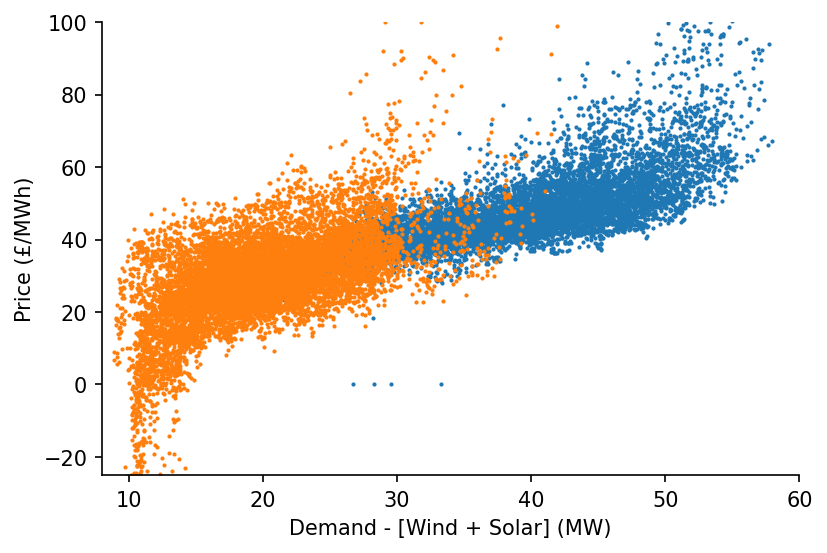

In [5]:
df_EI_model = df_EI[['day_ahead_price', 'demand', 'solar', 'wind']].dropna()

s_demand = df_EI_model['demand']
s_price = df_EI_model['day_ahead_price']
s_dispatchable = df_EI_model['demand'] - df_EI_model[['solar', 'wind']].sum(axis=1)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.scatter(s_dispatchable['2010-09':'2011-03'], s_price['2010-09':'2011-03'], s=1)
ax.scatter(s_dispatchable['2020-03':'2020-09'], s_price['2020-03':'2020-09'], s=1)

hlp.hide_spines(ax)
ax.set_xlim(8, 60)
ax.set_ylim(-25, 100)
ax.set_xlabel('Demand - [Wind + Solar] (MW)')
ax.set_ylabel('Price (£/MWh)')

<br>

As well as the DE data

Text(0, 0.5, 'Price (£/MWh)')

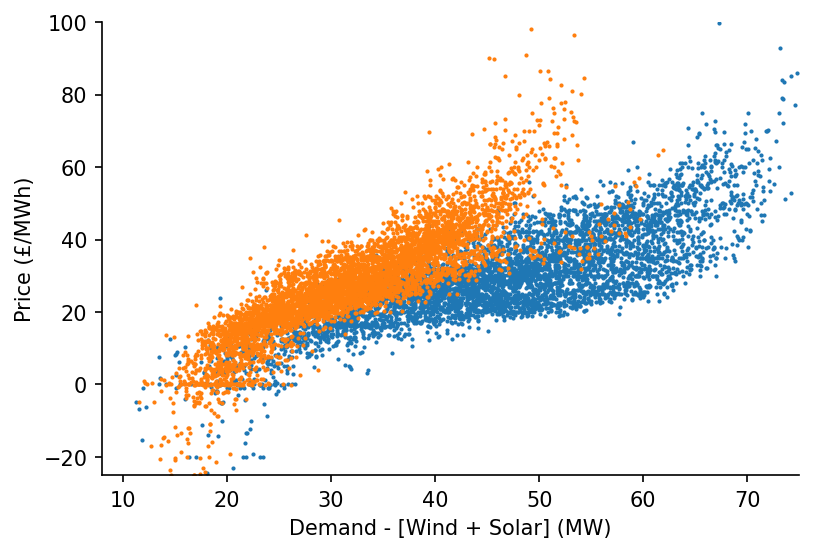

In [6]:
df_DE = eda.load_DE_df('../data/raw/energy_charts.csv', '../data/raw/ENTSOE_DE_price.csv')

df_DE_model = df_DE[['price', 'demand', 'Solar', 'Wind']].dropna()

s_DE_demand = df_DE_model['demand']
s_DE_price = df_DE_model['price']
s_DE_dispatchable = df_DE_model['demand'] - df_DE_model[['Solar', 'Wind']].sum(axis=1)

# Plotting
fig, ax = plt.subplots(dpi=150)

ax.scatter(s_DE_dispatchable['2015-09':'2016-03'], s_DE_price['2015-09':'2016-03'], s=1)
ax.scatter(s_DE_dispatchable['2020-03':'2020-09'], s_DE_price['2020-03':'2020-09'], s=1)

hlp.hide_spines(ax)
ax.set_xlim(8, 75)
ax.set_ylim(-25, 100)
ax.set_xlabel('Demand - [Wind + Solar] (MW)')
ax.set_ylabel('Price (£/MWh)')

<br>

### Results Wrapper

We'll start defining each of the price models that we'll fit, using the `PicklableFunction` class to ensure that all of our models can be saved for later use.

In [7]:
#exports
import copy
import types
import marshal

class PicklableFunction:
    """Provides a wrapper to ensure functions can be pickled"""
    def __init__(self, fun):
        self._fun = fun

    def __call__(self, *args, **kwargs):
        return self._fun(*args, **kwargs)

    def __getstate__(self):
        try:
            return pickle.dumps(self._fun)
        except Exception:
            return marshal.dumps((self._fun.__code__, self._fun.__name__))

    def __setstate__(self, state):
        try:
            self._fun = pickle.loads(state)
        except Exception:
            code, name = marshal.loads(state)
            self._fun = types.FunctionType(code, {}, name)
            
        return
          
def get_fit_kwarg_sets(qs=np.linspace(0.1, 0.9, 9)):
    """Helper to generate kwargs for the `fit` method of `Lowess`"""
    fit_kwarg_sets = [
        # quantile lowess
        { 
            'name': f'p{int(q*100)}',
            'lowess_kwargs': {'reg_func': PicklableFunction(lowess.calc_quant_reg_betas)},
            'q': q,
        }
        for q in qs

        # standard lowess
    ] + [{'name': 'average'}] 
    
    return fit_kwarg_sets

In [8]:
model_definitions = {
    'DAM_price_GB': {
        'dt_idx': s_dispatchable.index,
        'x': s_dispatchable.values,
        'y': s_price.values,
        'reg_dates_start': '2009-01-01',
        'reg_dates_end': '2021-01-01',
        'reg_dates_freq': '13W', # 13 
        'frac': 0.3, 
        'num_fits': 31, # 31
        'dates_smoothing_value': 26, # 26
        'dates_smoothing_units': 'W',
        'fit_kwarg_sets': get_fit_kwarg_sets(qs=[0.16, 0.5, 0.84])
    },
    'DAM_price_demand_GB': {
        'dt_idx': s_demand.index,
        'x': s_demand.values,
        'y': s_price.values,
        'reg_dates_start': '2009-01-01',
        'reg_dates_end': '2021-01-01',
        'reg_dates_freq': '13W', # 13 
        'frac': 0.3, 
        'num_fits': 31, # 31
        'dates_smoothing_value': 26, # 26
        'dates_smoothing_units': 'W',
        'fit_kwarg_sets': get_fit_kwarg_sets(qs=[0.5])
    },
    'DAM_price_DE': {
        'dt_idx': s_DE_dispatchable.index,
        'x': s_DE_dispatchable.values,
        'y': s_DE_price.values,
        'reg_dates_start': '2015-01-04',
        'reg_dates_end': '2021-01-01',
        'reg_dates_freq': '13W', # 13 
        'frac': 0.3, 
        'num_fits': 31, # 31
        'dates_smoothing_value': 26, # 26
        'dates_smoothing_units': 'W',
        'fit_kwarg_sets': get_fit_kwarg_sets(qs=[0.16, 0.5, 0.84])
    },
    'DAM_price_demand_DE': {
        'dt_idx': s_DE_dispatchable.index,
        'x': s_DE_demand.values,
        'y': s_DE_price.values,
        'reg_dates_start': '2015-01-04',
        'reg_dates_end': '2021-01-01',
        'reg_dates_freq': '13W', # 13 
        'frac': 0.3, 
        'num_fits': 31, # 31
        'dates_smoothing_value': 26, # 26
        'dates_smoothing_units': 'W',
        'fit_kwarg_sets': get_fit_kwarg_sets(qs=[0.5])
    }
}

<br>

We'll now take these model definitions to fit and save them

In [9]:
#exports
def fit_models(model_definitions, models_dir):
    """Fits LOWESS variants using the specified model definitions"""
    for model_parent_name, model_spec in model_definitions.items():
        for fit_kwarg_set in track(model_spec['fit_kwarg_sets'], label=model_parent_name):
            run_name = fit_kwarg_set.pop('name')
            model_name = f'{model_parent_name}_{run_name}'

            if f'{model_name}.pkl' not in os.listdir(models_dir):
                smooth_dates = lowess.SmoothDates()

                reg_dates = pd.date_range(
                    model_spec['reg_dates_start'], 
                    model_spec['reg_dates_end'], 
                    freq=model_spec['reg_dates_freq']
                )
                
                smooth_dates.fit(
                    model_spec['x'], 
                    model_spec['y'], 
                    dt_idx=model_spec['dt_idx'], 
                    reg_dates=reg_dates, 
                    frac=model_spec['frac'], 
                    threshold_value=model_spec['dates_smoothing_value'], 
                    threshold_units=model_spec['dates_smoothing_units'],
                    num_fits=model_spec['num_fits'], 
                    **fit_kwarg_set
                )
                
                model_fp = f'{models_dir}/{model_name}.pkl'
                pickle.dump(smooth_dates, open(model_fp, 'wb'))

                del smooth_dates

In [10]:
fit_models(model_definitions, models_dir)

   DAM_price_GB [█████████████████████████████████████████████] 4/4 [00:00<00:00, 0.00s/it]

DAM_price_deman [█████████████████████████████████████████████] 2/2 [00:00<00:00, 0.00s/it]

   DAM_price_DE [█████████████████████████████████████████████] 4/4 [00:00<00:00, 0.00s/it]

DAM_price_deman [█████████████████████████████████████████████] 2/2 [00:00<00:00, 0.00s/it]

<br>

We'll load one of the models in

In [14]:
%%time

if load_existing_model == True:
    smooth_dates = pickle.load(open(f'{models_dir}/DAM_price_GB_p50.pkl', 'rb'))
else:
    lowess_kwargs = {}
    reg_dates = pd.date_range('2009-01-01', '2021-01-01', freq='13W')

    smooth_dates = lowess.SmoothDates()
    smooth_dates.fit(s_dispatchable.values, s_price.values, dt_idx=s_dispatchable.index, 
                     reg_dates=reg_dates, frac=0.3, num_fits=31, threshold_value=26, lowess_kwargs=lowess_kwargs)

Wall time: 2.7 s


<br>

And create a prediction surface using it

In [15]:
%%time

x_pred = np.linspace(8, 60, 521)
dt_pred = pd.date_range('2009-01-01', '2021-01-01', freq='1W')

df_pred = smooth_dates.predict(x_pred=x_pred, dt_pred=dt_pred)

df_pred.head()

Wall time: 346 ms


,2009-01-04,2009-01-11,2009-01-18,2009-01-25,2009-02-01,2009-02-08,2009-02-15,2009-02-22,2009-03-01,2009-03-08,...,2020-10-25,2020-11-01,2020-11-08,2020-11-15,2020-11-22,2020-11-29,2020-12-06,2020-12-13,2020-12-20,2020-12-27
8.0,-7.660008,-7.789268,-7.910814,-8.025717,-8.134805,-8.238751,-8.338129,-8.433449,-8.525193,-8.613820,...,10.235374,10.292018,10.347611,10.402138,10.455693,10.508530,10.561129,10.614270,10.669140,10.727071
8.1,-7.467721,-7.596370,-7.717343,-7.831705,-7.940282,-8.043744,-8.142661,-8.237542,-8.328865,-8.417088,...,10.442911,10.499384,10.554824,10.609219,10.662661,10.715403,10.767921,10.820990,10.875787,10.933636
8.2,-7.275607,-7.403641,-7.524036,-7.637854,-7.745917,-7.848890,-7.947342,-8.041780,-8.132678,-8.220493,...,10.650337,10.706638,10.761927,10.816190,10.869521,10.922169,10.974607,11.027605,11.082331,11.140099
8.3,-7.083662,-7.211075,-7.330889,-7.444158,-7.551701,-7.654183,-7.752166,-7.846157,-7.936627,-8.024030,...,10.857636,10.913767,10.968906,11.023039,11.076259,11.128814,11.181173,11.234100,11.288756,11.346444
8.4,-6.891877,-7.018666,-7.137894,-7.250611,-7.357631,-7.459617,-7.557128,-7.650668,-7.740706,-7.827694,...,11.064795,11.120757,11.175747,11.229751,11.282861,11.335324,11.387606,11.440464,11.495050,11.552659


In [16]:
#hide
from nbdev.export import *
notebook2script()

Converted 01-retrieval.ipynb.
Converted 02-eda.ipynb.
Converted 03-lowess.ipynb.
Converted 04-price-surface-estimation.ipynb.
Converted 05-price-moe.ipynb.
Converted 06-carbon-surface-estimation-and-moe.ipynb.
Converted 07-prediction-confidence-and-intervals.ipynb.
Converted 08-hyper-parameter-tuning.ipynb.
Converted 09-tables-and-figures.ipynb.
